# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import datetime
from time import time

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Understanding

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [5]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
transcript.shape

(306534, 4)

In [13]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

## Data Cleaning/Wrangling

In [14]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


From the portfolio dataset, we can see that each channel can be in a seprate column instead of putting them all together.

In [15]:
#extract all channels names 

channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))
channels_set

{'email', 'mobile', 'social', 'web'}

There are four unique channel names in the channel column.

In [16]:
# Portfolio cleaning function 
def clean_portfolio(portfolio):
    '''
    Cleaning the portfolio dataset
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # Convert to datetime
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio


In [17]:
# Portfolio dataset after cleaning
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio.head()

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [18]:
# Profile cleaning function 
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    
    # Convert to datetime
    profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')
    
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    #profile['days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['year'] = profile['became_member_on'].apply(lambda x: x.year)
    
    
    return profile

In [19]:
# Profile dataset after cleaning
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,became_member_on,gender,id,income,year
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


In [20]:
# Iterate over transcript table, check value column and update it, put each key in seperated column.
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

In [21]:
clean_transcript = transcript.drop('value', axis=1)
clean_transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


## Exploratory Data Analysis

In [22]:
import seaborn as sns

In [23]:
def get_offer_type(offer_id):
    '''
    input: offer_id: id of offer
    
    output: offer type
    
    '''
    
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)


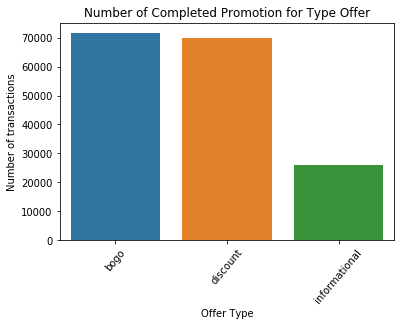

In [24]:
sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.xticks(rotation = 50);

From the chart above, we can see that BOGO is the highest offer followed by discount.

In [25]:
# display function 
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='What is the average age of Starbucks customers?')
    user_age.set_xlabel("Customer Age")
       
    # Display Histogram of the days being member
    plt.figure()
    days = cleaned_profile['year'].plot(kind='hist', bins=50,color ='#086A87', title='Year Customers became a Member')
    days.set_xlabel("Year")
    
    # Display Histogram of User Income
    plt.figure()
    income = cleaned_profile['income'].plot(kind='hist', bins=20, title='What is the average income for Starbucks customers?')
    income.set_xlabel("Income")
    
    # Display Histogram of user gender
    plt.figure()
    plt.hist(cleaned_profile['gender'], bins = 10);
    plt.xlabel('Gender');
    plt.title('Gender of Customer');

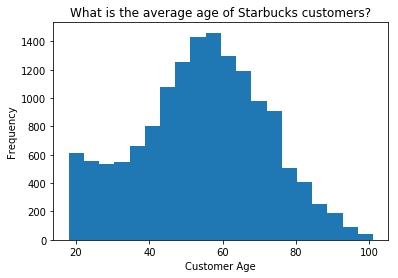

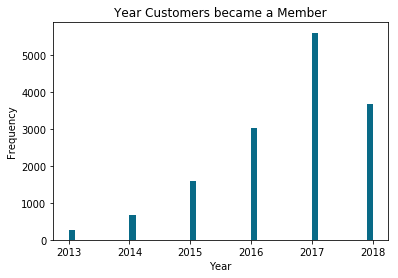

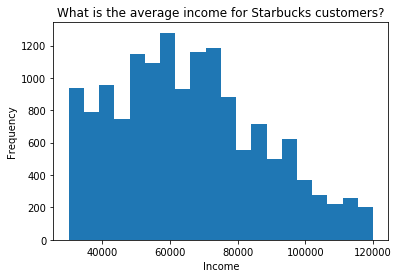

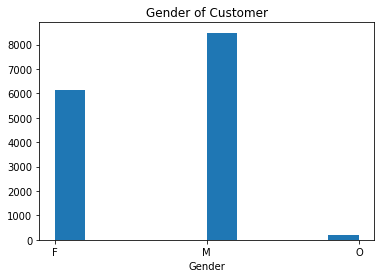

In [26]:
display_customer_profile()

Doing an exploratory data analysis on customer attributes as Age, income, gender, can give us some answers to our first and second questions, that men consume Starbucks products more than women with an average age of 54 (it’s a normal distribution), and an average income of 65404 ( it’s a right-skewed distribution), The highest number of membership was  recorded in 2017.

## Data Preparation

In [27]:
# from transcript dataset create dummies variable
transcript = pd.get_dummies(clean_transcript , columns=['event'] , prefix='' ,prefix_sep='')
transcript.head()

,person,time,offer_id,amount,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1,0,0


In [28]:
# from new transcript dataset drop duplicates
transcript.drop_duplicates(inplace=True)

In [29]:
transcript.duplicated().sum()

0

In [30]:
# merge new transcript dataset with profile 
merged = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')
merged.drop(columns=['id'] , inplace=True)
# Fill nans with 0
merged.reward.fillna(0 , inplace=True)
merged.amount.fillna(0 , inplace=True)
merged.head()

,person,time,offer_id,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,year
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,0,0,75.0,2017-05-09,F,100000.0,2017
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,0,1,0,75.0,2017-05-09,F,100000.0,2017
2,78afa995795e4d85b5d9ceeca43f5fef,132,,19,0,0,0,0,1,75.0,2017-05-09,F,100000.0,2017
3,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,1,0,0,0,75.0,2017-05-09,F,100000.0,2017
4,78afa995795e4d85b5d9ceeca43f5fef,144,,17,0,0,0,0,1,75.0,2017-05-09,F,100000.0,2017


In [31]:
# sort values
merged.sort_values(by=['time'] , ascending=True , inplace=True)

list1 = ['transaction', 'amount']

for i in list1:
    merged[i] = merged.groupby('person')[i].cumsum()

In [32]:
# drop missing values 
merged.dropna(subset=['offer_id'] ,inplace=True)

In [33]:
# merge the cleaned merged with protfolio
merged = merged.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')
merged.head()

,person,time,offer_id,amount,reward_x,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,year,channels,difficulty,duration,id,offer_type,reward_y
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,1,0,0,75.0,2017-05-09,F,100000.0,2017,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
1,ee5ea2e61fa349719dc5165fa20200dc,0,2906b810c7d4411798c6938adc9daaa5,0,0,0,1,0,0,62.0,2016-08-30,F,107000.0,2016,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0
2,ee5ea2e61fa349719dc5165fa20200dc,0,2906b810c7d4411798c6938adc9daaa5,0,0,0,0,1,0,62.0,2016-08-30,F,107000.0,2016,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0
3,4208fdb8007e44f989539c206e9c277c,0,3f207df678b143eea3cee63160fa8bed,0,0,0,1,0,0,76.0,2017-07-06,F,103000.0,2017,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0
4,d98654c04b694e7da1b10479b34b295e,0,3f207df678b143eea3cee63160fa8bed,0,0,0,1,0,0,60.0,2018-05-15,O,72000.0,2018,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0


In [34]:
Model_data = merged.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }
).reset_index()
Model_data.head()

,person,offer_type,offer completed,offer received,offer viewed,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,1,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,discount,2,2,1,33.0,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,informational,0,2,2,33.0,2017-04-21,M,72000.0
3,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,1,40.0,2018-01-09,O,57000.0
4,0011e0d4e6b944f998e987f904e8c1e5,discount,2,2,2,40.0,2018-01-09,O,57000.0


In [35]:
def offers_transformation(df):
    '''
    Function: to transform the offers
    
    Returns: The transformed offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0
    # Transform BOGO offer 
    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']
    # Transform dsicount offer
        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
    # groupby by person    
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()


In [36]:
trans_data = offers_transformation(Model_data)

In [37]:
trans_data.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33.0,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40.0,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59.0,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24.0,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26.0,2017-06-21,F,73000.0,0,0,3,3


In [38]:
# create colunms with the precnetage of each offer
trans_data['bogo_perce'] = trans_data.bogo_completed.div(trans_data.bogo_received.where(trans_data.bogo_received != 0, np.nan))*100
trans_data['discount_perce'] = trans_data.discount_completed.div(trans_data.discount_received.where(trans_data.discount_received != 0, np.nan))*100

In [39]:
trans_data.fillna(0 , inplace=True)

In [40]:
trans_data.isna().sum()

person                0
age                   0
became_member_on      0
gender                0
income                0
bogo_received         0
bogo_completed        0
discount_received     0
discount_completed    0
bogo_perce            0
discount_perce        0
dtype: int64

In [41]:
trans_data['bogo_offer'] = 0
trans_data['discount_offer'] = 0


for i ,row in trans_data.iterrows():

    if(row['bogo_perce'] >= 80):
        trans_data.loc[i , 'bogo_offer'] = 1
        
    if(row['discount_perce'] >= 80 ):
        trans_data.loc[i , 'discount_offer'] = 1

In [42]:
trans_data.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed,bogo_perce,discount_perce,bogo_offer,discount_offer
0,0009655768c64bdeb2e877511632db8f,33.0,2017-04-21,M,72000.0,1,1,2,2,100.0,100.0,1,1
1,0011e0d4e6b944f998e987f904e8c1e5,40.0,2018-01-09,O,57000.0,1,1,2,2,100.0,100.0,1,1
2,0020c2b971eb4e9188eac86d93036a77,59.0,2016-03-04,F,90000.0,2,1,2,2,50.0,100.0,0,1
3,0020ccbbb6d84e358d3414a3ff76cffd,24.0,2016-11-11,F,60000.0,2,2,1,1,100.0,100.0,1,1
4,003d66b6608740288d6cc97a6903f4f0,26.0,2017-06-21,F,73000.0,0,0,3,3,0.0,100.0,0,1


## Data Modeling

We will build a model that predict whether or not someone will respond to an offer, If the answer is yes, the model will choose discount or BOGO. 

In [43]:
mdata = trans_data.copy()
# create year and month columns from became_member_on column
mdata['year'] = mdata.became_member_on.dt.year
mdata['month'] = mdata.became_member_on.dt.month

In [44]:
# select necessary features 
mdata = mdata[['age' , 'gender' , 'income' ,
                           'year' , 'month' , 'discount_offer' ,
                           'bogo_offer']]
mdata.head()

,age,gender,income,year,month,discount_offer,bogo_offer
0,33.0,M,72000.0,2017,4,1,1
1,40.0,O,57000.0,2018,1,1,1
2,59.0,F,90000.0,2016,3,1,0
3,24.0,F,60000.0,2016,11,1,1
4,26.0,F,73000.0,2017,6,1,0


In [45]:
#dummies the gender column
new_mdata = pd.get_dummies(mdata , columns=['gender'])

In [46]:
# select features and target 
X = new_mdata.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = new_mdata.bogo_offer
y_discount = new_mdata.discount_offer
new_mdata.head()

,age,income,year,month,discount_offer,bogo_offer,gender_F,gender_M,gender_O
0,33.0,72000.0,2017,4,1,1,0,1,0
1,40.0,57000.0,2018,1,1,1,0,0,1
2,59.0,90000.0,2016,3,1,0,1,0,0
3,24.0,60000.0,2016,11,1,1,1,0,0
4,26.0,73000.0,2017,6,1,0,1,0,0


In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV

In [65]:
# split data set into train and test 
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

## Metrics
Since we have a simple classification problem, I will use accuracy to evaluate my models because we want to see how well our model is,by seeing the number of correct predictions vs total number of predicitons and also anwser the question of : How many custemrs use Starbucks offers?.This is my opinion and reason why I chose to use the easiest metric (accuracy).


1. AdaBoostClassifier Model

In [66]:
ABC_bogo = AdaBoostClassifier()
ABC_discount = AdaBoostClassifier()
ABC_bogo.fit(X_train, y_bogo_train)
ABC_discount.fit(X_train, y_discount_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [67]:
print(f'Bogo offer Accuracy of AdaBoostClassifier on training set: {round(ABC_bogo.score(X_train,y_bogo_train)*100,2)}%.')
print(f'Bogo offer Accuracy of AdaBoostClassifier on test set: {round(ABC_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of AdaBoostClassifier on training set: {round(ABC_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of AdaBoostClassifier on test set: {round(ABC_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of AdaBoostClassifier on training set: 67.54%.
Bogo offer Accuracy of AdaBoostClassifier on test set: 66.67%.
Discount offer Accuracy of AdaBoostClassifier on training set: 65.61%.
Discount offer Accuracy of AdaBoostClassifier on test set: 65.1%.


2. KNeighboursClassifier Model

In [68]:
KNN_bogo = KNeighborsClassifier()
KNN_discount = KNeighborsClassifier()
KNN_bogo.fit(X_train, y_bogo_train)
KNN_discount.fit(X_train, y_discount_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [69]:
print(f'Bogo offer Accuracy of KNeighborsClassifier on training set: {round(KNN_bogo.score(X_train,y_bogo_train)*100,2)}%.')
print(f'Bogo offer Accuracy of KNeighborsClassifier on test set: {round(KNN_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of KNeighborsClassifier on training set: {round(KNN_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of KNeighborsClassifier on test set: {round(KNN_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of KNeighborsClassifier on training set: 73.13%.
Bogo offer Accuracy of KNeighborsClassifier on test set: 57.38%.
Discount offer Accuracy of KNeighborsClassifier on training set: 71.43%.
Discount offer Accuracy of KNeighborsClassifier on test set: 54.3%.


3. Logistic Regression Model

In [70]:
LR_bogo = LogisticRegression()
LR_discount = LogisticRegression()
LR_bogo.fit(X_train, y_bogo_train)
LR_discount.fit(X_train, y_discount_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
print(f'Bogo offer Accuracy of LogisticRegression on training set: {round(LR_bogo.score(X_train,y_bogo_train)*100,2)}%.')
print(f'Bogo offer Accuracy of LogisticRegression on test set: {round(LR_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of LogisticRegression on training set: {round(LR_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of LogisticRegression on test set: {round(LR_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of LogisticRegression on training set: 61.29%.
Bogo offer Accuracy of LogisticRegression on test set: 61.78%.
Discount offer Accuracy of LogisticRegression on training set: 59.02%.
Discount offer Accuracy of LogisticRegression on test set: 58.7%.


4. DecissionTreeClassifier Model

In [72]:
DT_bogo = DecisionTreeClassifier()
DT_discount = DecisionTreeClassifier()
DT_bogo.fit(X_train, y_bogo_train)
DT_discount.fit(X_train, y_discount_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [73]:
print(f'Bogo offer Accuracy of DecisionTreeClassifier on training set: {round(DT_bogo.score(X_train,y_bogo_train)*100,2)}%.')
print(f'Bogo offer Accuracy of DecisionTreeClassifier on test set: {round(DT_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of DecisionTreeClassifier on training set: {round(DT_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of DecisionTreeClassifier on test set: {round(DT_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of DecisionTreeClassifier on training set: 99.19%.
Bogo offer Accuracy of DecisionTreeClassifier on test set: 58.76%.
Discount offer Accuracy of DecisionTreeClassifier on training set: 99.19%.
Discount offer Accuracy of DecisionTreeClassifier on test set: 57.33%.


## Model Results

In [74]:
models_bogo = [ABC_bogo, KNN_bogo, LR_bogo, DT_bogo ]
models_discount = [ABC_discount, KNN_discount, LR_discount, DT_discount]
model_names = [type(n).__name__ for n in models_bogo]
bogo_tr_accuracy = [x1.score(X_train, y_bogo_train)*100 for x1 in models_bogo]
discount_tr_accuracy = [x2.score(X_train, y_discount_train)*100 for x2 in models_discount]
bogo_test_accuracy = [y1.score(X_test,y_bogo_test)*100 for y1 in models_bogo]
discount_test_accuracy = [y2.score(X_test,y_discount_test)*100 for y2 in models_discount]

In [75]:
results = [bogo_tr_accuracy,bogo_test_accuracy,discount_tr_accuracy,discount_test_accuracy]
results_df = pd.DataFrame(results, columns = model_names,index=['Bogo Training Accuracy', 'Bogo Test Accuracy','Discount Training Accuracy', 'Discount Test Accuracy']) 
results_df

,AdaBoostClassifier,KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier
Bogo Training Accuracy,67.539361,73.126406,61.286550,99.190283
Bogo Test Accuracy,66.666667,57.381916,61.781377,58.758435
Discount Training Accuracy,65.614035,71.426001,59.019343,99.190283
Discount Test Accuracy,65.101215,54.304993,58.704453,57.327935


My analysis suggests that the resulting DecisionTreeClassifier model has an bogo training data accuracy of 99 and bogo test accuracy of 58 . discount training accuracy of 99 and discount test accuracy of 57 suggests that the DecisionTreeClassifier model I constructed did not overfit the training data.

## Model Improvement
I will use Grid Search with DecisionTree to Improve the model to get better results.

In [76]:
# Tuning to get better accuracy
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

# create and fit a DecisionTree model

DT_bogo = DecisionTreeClassifier()
grid_bogo = GridSearchCV(estimator=DT_bogo, param_grid=tree_para,cv=2,n_jobs = -1)
grid_bogo_result = grid_bogo.fit(X_train, y_bogo_train)
DT_discount = DecisionTreeClassifier()
grid_discount = GridSearchCV(estimator=DT_discount, param_grid=tree_para,cv=2,n_jobs = -1)
grid_discount_result = grid_discount.fit(X_train, y_discount_train)

# summarize the results of the random parameter search

print(f'Best bogo model Score: {grid_bogo_result.best_score_}')
print(f'Best bogo model params: {grid_bogo_result.best_params_}')
print(f'Best discount model Score: {grid_discount_result.best_score_}')
print(f'Best discount model params: {grid_discount_result.best_params_}')

Best bogo model Score: 0.6824111560953666
Best bogo model params: {'criterion': 'entropy', 'max_depth': 6}
Best discount model Score: 0.6526315789473685
Best discount model params: {'criterion': 'entropy', 'max_depth': 5}


## Conclusion

In this Project,I analyzed and built a model that predicts whether a customer will respond to an offer. If yes,the model will choose the best offer type (discount or bogo). The Strategy I used for solving this problem has two steps. Firstly,I merged offer portfolio, customer profile, and transaction data. Secondly, I built models for BOGO offer and Discount offer.The analysis suggests that Decision Tree model has the best training data accuracy.
My Conclusion is that,the Company should focus more on BOGO and Discount offers since they are the one that tend to make customers buy more.



## Improvements
I think I got to a point where I had good results and a good understanding of the data. But to make our results even better, It would be better to improve the data collection and fix issues with NaN values and also try to get more data like location, and when the transaction was completed, which branch and what time of the day. All these data can help us know when and where to give our offers.